<a href="https://colab.research.google.com/github/elveros83/HMN-RL-BASIC/blob/master/electric_meter_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/meter1.txt', sep='\t')

In [ ]:
df.isnull().sum()

LP_RECV_YMD    0
LP_RECV_HM     0
LP_METER_ID    0
CUST_CATEG     0
LP_FAP         0
LP_USAGE       1
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

LP_RECV_YMD    0
LP_RECV_HM     0
LP_METER_ID    0
CUST_CATEG     0
LP_FAP         0
LP_USAGE       0
dtype: int64

In [ ]:
df.tail()

,LP_RECV_YMD,LP_RECV_HM,LP_METER_ID,CUST_CATEG,LP_FAP,LP_USAGE
739,20180831,1900,2171847750,211,42594.38,1.60
740,20180831,2000,2171847750,211,42596.37,1.99
741,20180831,2100,2171847750,211,42597.94,1.57
742,20180831,2200,2171847750,211,42599.52,1.58
743,20180831,2300,2171847750,211,42601.43,1.91


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 1 to 743
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LP_RECV_YMD  743 non-null    int64  
 1   LP_RECV_HM   743 non-null    int64  
 2   LP_METER_ID  743 non-null    int64  
 3   CUST_CATEG   743 non-null    int64  
 4   LP_FAP       743 non-null    float64
 5   LP_USAGE     743 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 40.6 KB


In [ ]:
import csv
time_step = []
temps = []
step = 0

for index, row in df.iterrows():
  temps.append(float(row['LP_USAGE']))
  # time_step.append(str(int(row['LP_RECV_YMD'])) + str(int(row['LP_RECV_HM'])).zfill(4))
  time_step.append(step)
  step = step + 1

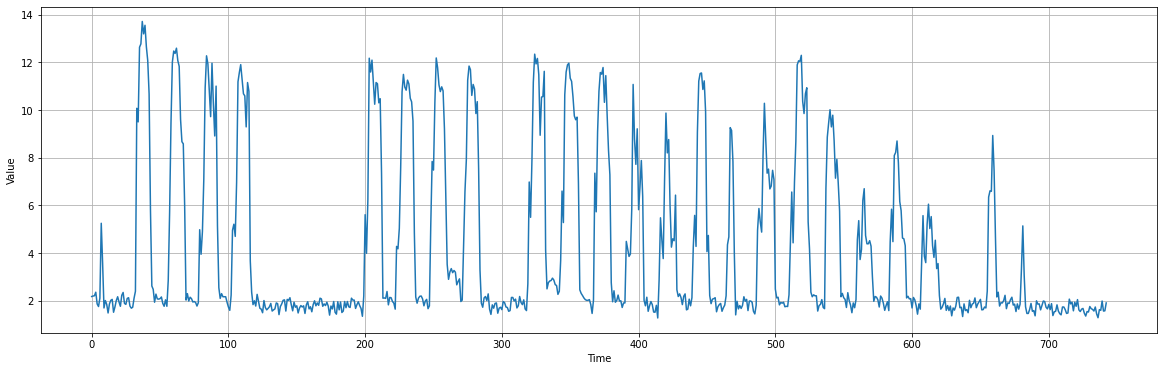

In [ ]:
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 6))

plot_series(time, series)

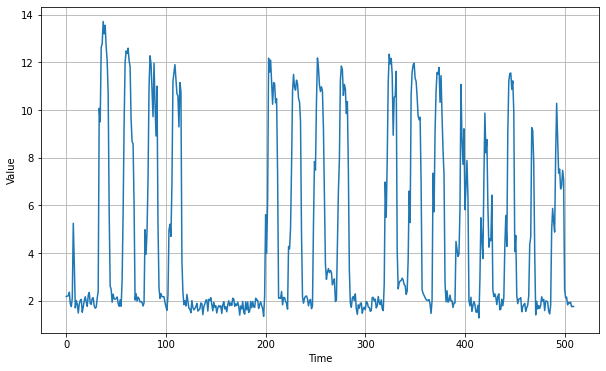

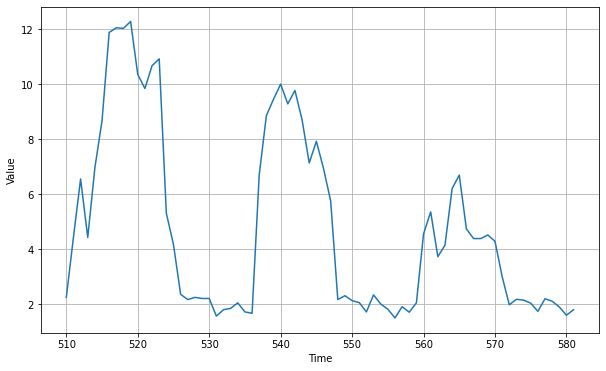

In [ ]:
split_start = 510
split_end = 582

time_train = time[:split_start]
x_train = series[:split_start]
time_valid = time[split_start:split_end]
x_valid = series[split_start:split_end]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [ ]:
naive_forecast = series[split_start - 1:split_end-1]

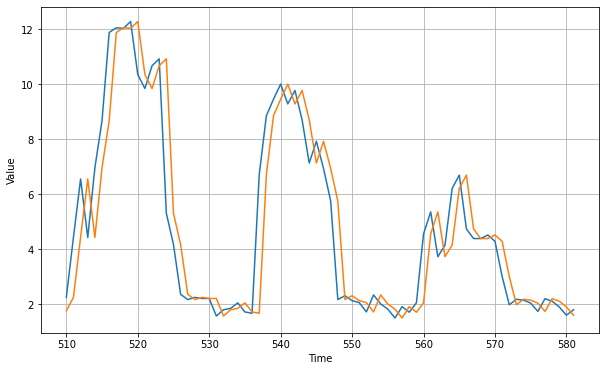

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

2.069316666666667
0.9083333333333334


In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

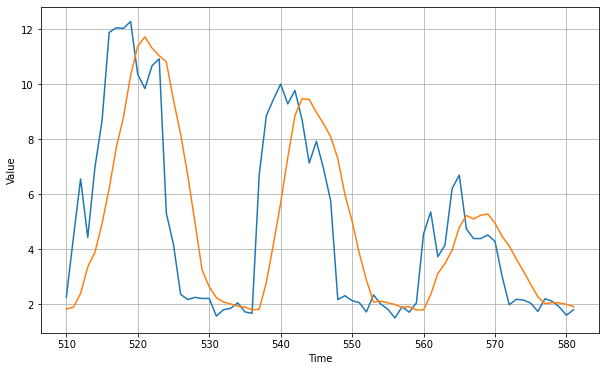

In [ ]:
moving_avg = moving_average_forecast(series, 5)[split_start - 5:split_end - 5]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

6.3973525
1.8251388888888893


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 24
batch_size = 16
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 10.0)

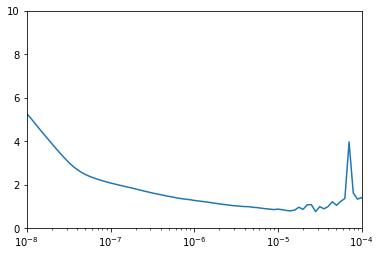

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 10])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [ ]:
rnn_forecast = rnn_forecast[split_start - window_size:split_end - window_size, -1, 0]

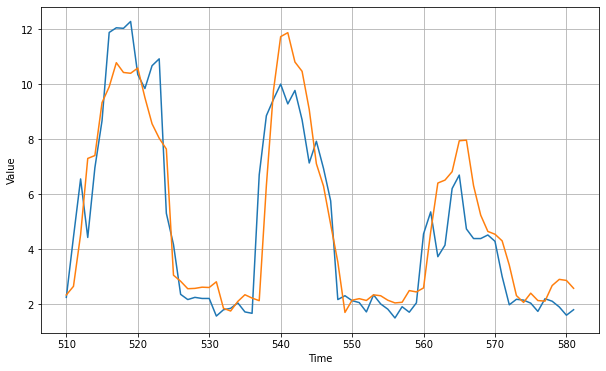

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

1.9878373
1.0498915
